In [104]:
import pandas as pd

# Path to your file (replace with the path to the file you uploaded)
GDP_Data = pd.read_csv('GDP_Data.csv', skiprows=3)

# Load the Capital Stock Data
Capital_Stock_Data = pd.read_csv('Capital_Stock_Data.csv', skiprows=3)

# Load the Gross Savings Data
Gross_Savings_Data = pd.read_csv('Gross_Savings_Data.csv', skiprows=3)

# Load the Population Data
Population_Data = pd.read_csv('Population_Data.csv', skiprows=3)

# Load the Labor Force Data
Labor_Force_Data = pd.read_csv('Labor_Force_Data.csv', skiprows=3)

# List of countries to include
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Filter for the selected countries
GDP_Data1 = GDP_Data[GDP_Data['Country Name'].isin(selected_countries)]
Capital_Stock_Data1 = Capital_Stock_Data[Capital_Stock_Data['Country Name'].isin(selected_countries)]
Gross_Savings_Data1 = Gross_Savings_Data[Gross_Savings_Data['Country Name'].isin(selected_countries)]
Population_Data1 = Population_Data[Population_Data['Country Name'].isin(selected_countries)]
Labor_Force_Data1 = Labor_Force_Data[Labor_Force_Data['Country Name'].isin(selected_countries)]

# Select the first three columns, plus the columns within the year range 1991-2023
columns_GDP = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in GDP_Data.columns if col.isdigit() and 1991 <= int(col) <= 2023]

columns_GDI = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in Capital_Stock_Data.columns if col.isdigit() and 1991 <= int(col) <= 2023]

columns_Pop = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in Population_Data.columns if col.isdigit() and 1990 <= int(col) <= 2023]

columns_savings = ["Country Name", "Country Code", "Indicator Name"] + \
                  [col for col in Gross_Savings_Data.columns if col.isdigit() and 1991 <= int(col) <= 2023]

columns_labor = ["Country Name", "Country Code", "Indicator Name"] + \
                [col for col in Labor_Force_Data.columns if col.isdigit() and 1991 <= int(col) <= 2023]

# Apply the columns filter to each dataset
GDP_Data2 = GDP_Data1[columns_GDP]
Capital_Stock_Data2 = Capital_Stock_Data1[columns_GDP]
Population_Data2 = Population_Data1[columns_Pop]
Gross_Savings_Data2 = Gross_Savings_Data1[columns_savings]
Labor_Force_Data2 = Labor_Force_Data1[columns_labor]

# Define a function to calculate annual growth
def calculate_annual_growth(row):
    growth_rates = {}
    for year in range(1991, 2024):
        growth_rates[str(year)] = ((row[str(year)] - row[str(year - 1)]) / row[str(year - 1)])
    return pd.Series(growth_rates)

# Apply the function to each row and create the Population Growth Data
Population_Growth_Data = Population_Data2.apply(calculate_annual_growth, axis=1)

# Add back the identifier columns
Population_Growth_Data = pd.concat([Population_Data2[["Country Name", "Country Code", "Indicator Name"]], Population_Growth_Data], axis=1)

# Rename "Population, growth" in the Indicator Name column to "Pop Annual Growth Rate"
Population_Growth_Data["Indicator Name"] = Population_Growth_Data["Indicator Name"].replace("Population, total", "Pop Annual Growth Rate")

# Define a function to calculate savings rate from total savings and total gdp
def calculate_savings_rate(row):
    savings_rate = {}
    for year in range(1991, 2024):
        year_str = str(year)
        if year_str in row.index and year_str in GDP_Data2.columns:
            # Locate the corresponding GDP value
            gdp_value = GDP_Data2.loc[row.name, year_str]
            savings_rate[year_str] = (row[year_str] / gdp_value)
    return pd.Series(savings_rate)

# Apply the function to each row in the Gross Savings Data to create Savings Rate Data
Savings_Rate_Data = Gross_Savings_Data2.iloc[:, 3:].apply(calculate_savings_rate, axis=1)

# Add back the identifier columns
Savings_Rate_Data = pd.concat([Gross_Savings_Data2[["Country Name", "Country Code", "Indicator Name"]], Savings_Rate_Data], axis=1)

# Save the resulting datasets to the Excel file
with pd.ExcelWriter('Project_Data.xlsx') as writer:
    GDP_Data2.to_excel(writer, sheet_name='GDP Data', index=False)
    Capital_Stock_Data2.to_excel(writer, sheet_name='Capital Stock Data', index=False)
    Savings_Rate_Data.to_excel(writer, sheet_name='Savings Rate Data', index=False)
    Population_Growth_Data.to_excel(writer, sheet_name='Population Data', index=False)
    Labor_Force_Data2.to_excel(writer, sheet_name='Labor Force Data', index=False)



In [105]:

# Fixed Parameters for Solow Model
alpha = 0.3      # Capital share of output
delta = 0.05     # Depreciation rate
g = 0.02         # Technological growth rate 

# Define a function to calculate steady-state k for a single row (country)
def calculate_steady_state_k(row):
    steady_state_k = {}
    for year in range(1991, 2024):
        year_str = str(year)
        if (
            year_str in Savings_Rate_Data.columns and
            year_str in Population_Growth_Data.columns and
            year_str in GDP_Data2.columns and
            year_str in Labor_Force_Data2.columns
        ):
            s = row[year_str]  
            n = Population_Growth_Data.loc[row.name, year_str] 
            y = GDP_Data2.loc[row.name, year_str]
            l = Labor_Force_Data2.loc[row.name, year_str]

            steady_state_k[year_str] = (s / (n + g + delta))**(1/(1-alpha))

    return pd.Series(steady_state_k)

# Apply the function to calculate steady-state k for all countries and years
Steady_State_k = Savings_Rate_Data.iloc[:, 3:].apply(calculate_steady_state_k, axis=1)

# Add back the identifier columns
Steady_State_k = pd.concat([Savings_Rate_Data[["Country Name", "Country Code", "Indicator Name"]], Steady_State_k], axis=1)

# Save the resulting dataset to a new Excel sheet
with pd.ExcelWriter('Project_Data.xlsx', mode='a', engine='openpyxl') as writer:
    Steady_State_k.to_excel(writer, sheet_name='Steady State K', index=False)



/tmp/ipykernel_1030/274613077.py:22: RuntimeWarning: invalid value encountered in scalar power
  steady_state_k[year_str] = (s / (n + g + delta))**(1/(1-alpha))


In [108]:
# Load the datasets
file_name = 'Project_Data.xlsx'  # File name in the same directory
Steady_State_k = pd.read_excel(file_name, sheet_name='Steady State K')
Capital_Stock_Data2 = pd.read_excel(file_name, sheet_name='Capital Stock Data')
Labor_Force_Data2 = pd.read_excel(file_name, sheet_name='Labor Force Data')

# Define a function to calculate the difference between steady-state k and actual k/L
def calculate_difference(row):
    country = row.name  # Get the country name
    differences = {}
    for year in range(1991, 2024):
        year_str = str(year)
        if (
            year_str in Capital_Stock_Data2.columns
            and year_str in Labor_Force_Data2.columns
            and year_str in Steady_State_k.columns
        ):
            capital_stock = Capital_Stock_Data2.loc[country, year_str]
            labor_force = Labor_Force_Data2.loc[country, year_str]
            steady_state_k = Steady_State_k.loc[country, year_str]

            # Ensure data is valid
            if not pd.isnull(capital_stock) and not pd.isnull(labor_force) and labor_force > 0:
                actual_k_l = capital_stock / labor_force
                differences[year_str] = capital_stock - actual_k_l
            else:
                differences[year_str] = None  # Handle missing or invalid data
    return pd.Series(differences)

# Apply the function to calculate differences for all countries and years
Difference_Data = Capital_Stock_Data2.iloc[:, 2:].apply(calculate_difference, axis=1)

# Add back the identifier columns
Difference_Data = pd.concat([
    Capital_Stock_Data2.reset_index()[["Country Name", "Country Code"]],
    pd.DataFrame({"Indicator Name": ["k* - k/l"] * Difference_Data.shape[0]}),
    Difference_Data
], axis=1)

# Save the resulting dataset to a new Excel sheet
output_path = 'Project_Data.xlsx'  # Adjust the filename if needed
with pd.ExcelWriter(output_path, mode='a', engine='openpyxl') as writer:
    Difference_Data.to_excel(writer, sheet_name='Difference Data', index=False)

<Figure size 1000x600 with 0 Axes>

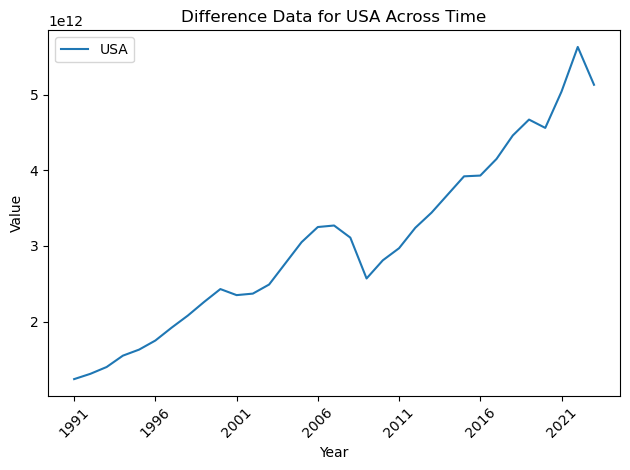

In [109]:


# Load the dataset
file_path = 'Project_Data.xlsx'

# Load the "Difference Data" sheet
difference_data = pd.read_excel(file_path, sheet_name='Difference Data')

# Filter data for USA
usa_data = difference_data[difference_data['Country Name'] == 'United States']

# Transpose the data to have years as the index and the indicator values as columns
usa_data_transposed = usa_data.drop(columns=['Country Name', 'Country Code', 'Indicator Name']).transpose()
usa_data_transposed.columns = ['USA']

# Plotting the data
plt.figure(figsize=(10, 6))
usa_data_transposed.plot(title='Difference Data for USA Across Time', xlabel='Year', ylabel='Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
